<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_5_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

Added a discriminator and training as a GAN (but still with autoencoder) to see if that improves the results.

In [0]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [11]:
!gsutil cp gs://{bucket_name}/gen_model_40.pt ./gen_model_4.pt 
!gsutil cp gs://{bucket_name}/disc_model_40.pt ./disc_model_4.pt 

Copying gs://pneumonia/model_31.pt...
/ [1 files][294.9 MiB/294.9 MiB]                                                
Operation completed over 1 objects/294.9 MiB.                                    


In [4]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

Copying gs://pneumonia/celeba-dataset.zip...
- [1 files][  1.2 GiB/  1.2 GiB]   93.5 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [0]:
if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

In [4]:
if not os.path.exists("wiki_images2.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
  zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()
  
if not os.path.exists("imdb_images3.zip"):
  !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
  zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()    

Copying gs://pneumonia/wiki_images2.zip...
| [1 files][160.5 MiB/160.5 MiB]                                                
Operation completed over 1 objects/160.5 MiB.                                    
Copying gs://pneumonia/imdb_images3.zip...
- [1 files][  1.5 GiB/  1.5 GiB]  103.1 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [5]:
# get test data
# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# if not os.path.exists("faces96.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
#   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

if not os.path.exists("faces95.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
  zip_ref = zipfile.ZipFile('faces95.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
if not os.path.exists("GWB_200x200_JPEG.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
  zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()    

if not os.path.exists("crop_part1.tar.gz"):
  !gsutil cp gs://{bucket_name}/crop_part1.tar.gz ./crop_part1.tar.gz
  !tar -xf crop_part1.tar.gz -C data/test_images

--2019-05-20 13:31:41--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.154.41
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.154.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15795698 (15M) [application/zip]
Saving to: ‘GWB_200x200_JPEG.zip’

GWB_200x200_JPEG.zi 100%[===================>]  15.06M  73.2MB/s    in 0.2s    

2019-05-20 13:31:41 (73.2 MB/s) - ‘GWB_200x200_JPEG.zip’ saved [15795698/15795698]



In [0]:
BATCH_SIZE = 16
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=False, fillcolor=0),        
      ], 0.4),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.85, 1.15)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((192,160), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

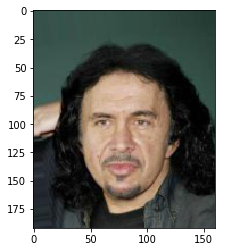

In [7]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

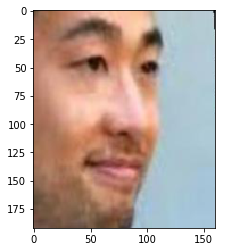

In [8]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 393598
    Root Location: data/images
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomApply(
                             p=0.4
                             RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05), scale=(0.9, 1.1), shear=(-2, 2))
                         )
                             RandomResizedCrop(size=(192, 160), scale=(0.85, 1.15), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [10]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 11684
    Root Location: data/test_images
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(192, 160), scale=(0.95, 1.05), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

### Bigger Model

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, mu=None, logvar=None, d_faked=None):
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat)
    
    # variational loss IF we are doing variational
    if mu is not None and logvar is not None:
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      KLD /= BATCH_SIZE * 784
      MSE = MSE + KLD
    
    if d_faked is not None:
        ones = torch.ones(BATCH_SIZE).cuda()
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
        MSE *= 20
        MSE += g_loss
        
    return MSE
  
def disc_loss(d_true, d_faked):
    ones = torch.ones(BATCH_SIZE).cuda()
    zeros = torch.zeros(BATCH_SIZE).cuda()
    d_loss_real = nn.functional.binary_cross_entropy_with_logits(d_true, ones, reduction="mean")
    d_loss_fake = nn.functional.binary_cross_entropy_with_logits(d_faked, zeros, reduction="mean")
    d_loss = d_loss_real + d_loss_fake


    return d_loss

def train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=False, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_4.pt", g_save_path="g_model_4.pt"):
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          d_tr_loss = 0.0
          g_tr_loss = 0.0
          d_test_loss = 0.0
          g_test_loss = 0.0
          
          batch_losses = []
          batch_accuracies = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              d_optimizer.zero_grad()
              g_optimizer.zero_grad()
              
              # generate our fake images
              recon, code, logvar = generator(inputs)
             
              # feed the fake images into the discriminator
              faked_logits = discriminator(recon)
              
              # feed the real images into the discriminator
              real_logits = discriminator(inputs)
              d_loss = disc_loss(real_logits, faked_logits)
              
              # update the discriminator every other step to give the generator time to catch up
              if i % 2 == 0:
                d_loss.backward(retain_graph=True)
                d_optimizer.step()

              # calculate the accuracy of our discriminator
              fake_preds = torch.sigmoid(faked_logits)
              real_preds = torch.sigmoid(real_logits)
              
              fake_acc = torch.sum(fake_preds < 0.5).double()
              real_acc = torch.sum(real_preds >= 0.5).double()
              d_accuracy = (fake_acc + real_acc) / (BATCH_SIZE * 2.0)
              batch_accuracies.append(d_accuracy.item())
              
              # update the generator
              g_loss = vae_loss(inputs, recon, code, logvar=None, d_faked=faked_logits)
              if train_gen:
                g_loss.backward()
                g_optimizer.step()
              g_tr_loss += g_loss.item()
                  
              d_tr_loss += d_loss.item()
              batch_losses.append(g_loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen loss:", g_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(discriminator.state_dict(), d_save_path)
              torch.save(generator.state_dict(), g_save_path)
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss = vae_loss(inputs, recon, code, logvar=None)

                test_loss += loss.item()

            try:
                fig, ax = plt.subplots(2, 2, figsize=(7,7))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss)
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              g_scheduler.step()
              
          if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        

def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_4.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_loss = 0.0
          test_loss = 0
          batch_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()
              
              recon, code, logvar = model(inputs)
              if model.variational:
                  loss = vae_loss(inputs, recon, code, logvar=logvar)
              else:  
                  loss = vae_loss(inputs, recon, code, logvar=None)

              loss.backward()
              optimizer.step()

              tr_loss += loss.item()
              batch_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", loss.item())

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss = vae_loss(inputs, recon, code, logvar=None)

                test_loss += loss.item()

            try:
                fig, ax = plt.subplots(2, 2, figsize=(7,7))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", tr_loss, "Test Loss:", test_loss)
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
    
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params               

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
          self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
          logvar = self.fc2(concat)
        else:
          logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(512)
        
        self.fc1 = nn.Conv2d(512, 1024, 1) # code layer
        self.fc2 = nn.Conv2d(1024, 1, 1)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def discriminate(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        mp1 = self.max_pool(h3)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        mp2 = self.max_pool(h6)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        mp3 = self.max_pool(h9)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        mp4 = self.max_pool(h11)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        mp5 = self.max_pool(h13)
        gap = self.dropout1(self.gap(mp5))
        
        # input 4x4x64 - output latent_dimx1
        fc1 = self.dropout2(self.relu(self.fc1(gap)))
        logits = self.fc2(fc1)
        
        return torch.squeeze(logits)
  
    def forward(self, x):
        return self.discriminate(x)

In [45]:
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
discriminator = Discriminator()
generator = SingleModel(encoder, decoder)
#params = list(encoder.parameters()) + list(decoder.parameters())
params = generator.parameters()

print("Autoencoder Params:", count_params(generator))
print("Discriminator Params:", count_params(discriminator))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
g_optimizer = optim.Adam(params, lr=0.0005)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0009)
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.98)
d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.98)

try:
    generator.load_state_dict(torch.load("gen_model_4.pt"))
    print("Autoencoder loaded")
except:
    print("Error loading autoencoder")
    
try:
    discriminator.load_state_dict(torch.load("disc_model_4.pt"))
    print("Discriminator loaded")
except:
    print("Error loading discriminator")    

Total Params: 77289667
Discriminator Params: 5436737
Generator loaded
Discriminator loaded


In [0]:
train_discriminator(discriminator, generator, train_loader, d_optimizer=d_optimizer, g_optimizer=g_optimizer, print_metrics=1000, train_gen=True, plot_images=2000, num_epochs=1, display_images=1, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_4.pt", g_save_path="gen_model_4.pt")

In [41]:
with torch.no_grad():
  for (inputs,_) in train_loader:
    recon, mu, logvar = generator(inputs.cuda())
    faked_logits = discriminator(recon)
    vae_loss(inputs.cuda(), recon, mu, logvar=None, d_faked=faked_logits)
    break

G_loss: tensor(1.0436, device='cuda:0')
MSE: tensor(1.3465, device='cuda:0')


In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

In [0]:
train(model, train_loader=train_loader2, optimizer=optimizer, print_metrics=10, plot_images=1, num_epochs=25, display_images=1, scheduler=scheduler)

In [0]:
train(model, train_loader=train_loader2, optimizer=optimizer, print_metrics=10, plot_images=1, num_epochs=30, display_images=1, scheduler=scheduler)

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()